# Explore Publicly-traded Genomics Companies

In [1]:
from bs4 import BeautifulSoup
import datetime
import json
import lxml
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
import re
import requests
from wordcloud import WordCloud, STOPWORDS
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100
api_key = os.environ['QUANDL']

### Load data from local files and QUANDL API

In [2]:
ark_genomics_list = pd.read_csv('data/ark_genomics.txt', header=None)[0].tolist()
missing_websites = pd.read_json('data/websites.jsonl', lines=True).set_index('ticker').to_dict()['website']
words_of_interest = pd.read_json('data/terms.jsonl', lines=True)


def import_table(db, api_key=api_key):
    
    url = (
        'https://www.quandl.com/api/v3/datatables/SHARADAR/'
        f'{db}?qopts.export=true&api_key={api_key}'
    )
    fp = f'{db}.zip'

    r = requests.get(requests.get(url).json()['datatable_bulk_download']['file']['link'])
    with open(fp, 'wb') as f:
        f.write(r.content)

    data = pd.read_csv(fp)
    os.remove(fp)

    return data

tickers_metadata = import_table('TICKERS')
sf1data = import_table('SF1')
sf1data_mrt = sf1data[sf1data['dimension']=='MRT'].reset_index(drop=True)

### Select Genomics-sector Companies
Select companies in the field of genomics by their industry label.  
Exclude any that aren't listed on the NASDAQ or NYSE exchanges and any that are located in China. Exclude stock warrants and preferred or secondary stock, so that there is only the one primary stock included per company.

In [3]:
genomics_industry_list = [
    'Agricultural Inputs',
    'Biotechnology',
    'Chemicals',
    'Diagnostics & Research',
    'Drug Manufacturers - General',
    'Farm Products',
    'Health Information Services',
    'Medical Devices'
]
genomics_companies = (
    tickers_metadata[
        (tickers_metadata['isdelisted']=='N')&
        (tickers_metadata['industry'].isin(genomics_industry_list))&
        (tickers_metadata['exchange'].isin(['NASDAQ', 'NYSE']))&
        (~tickers_metadata['category'].isin(['Domestic Stock Warrant', 'ADR Stock Warrant', 'Domestic Common Stock Secondary Class', 'Domestic Preferred Stock']))&
        (~tickers_metadata['location'].isin(['China', 'Hong Kong']))&
        (tickers_metadata['ticker'].isin(sf1data_mrt['ticker'].tolist()))
    ]
    [['ticker', 'name', 'exchange', 'category', 'sector', 'industry', 'scalemarketcap', 'scalerevenue', 'location', 'firstpricedate', 'firstquarter', 'companysite']]
    .rename(columns={'name': 'companyname'})
    .drop_duplicates()
    .sort_values('ticker')
    .reset_index(drop=True)
)
# add website url from text file for those companies that were missing it in the data from QUANDL
genomics_companies['companysite'] = genomics_companies.apply(
    lambda x:
    missing_websites[x.ticker]
    if pd.isnull(x.companysite) or x.ticker in missing_websites.keys()
    else x.companysite,
    axis=1
)
len(genomics_companies)

972

### Scrape company websites
We'll scrape the base url site for each company, retrieving the text from the company's website landing page. For a more comprehensive analysis, we could expand this to scrape all sub-pages of the website as well.  

For accessing the website content, we'll use python's Requests library; and for parsing this html content into text, we'll use BeautifulSoup. We'll split all the text into individual words.

In [4]:
pattern = re.compile('[\W_]+')

def get_website_words(url):
    try:
        r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}, timeout=30)
        page_content = BeautifulSoup(r.content, 'lxml')
        words = [
            z.lower()
            for z in [
                y
                for x in [
                    pattern.sub(' ', x).strip()
                    for x in page_content.text.splitlines()
                ]
                for y in x.split()
            ]
            if not z.isdigit() and len(z)>1
        ]
        return words
    except:
        return []

genomics_companies['companysite_words'] = genomics_companies['companysite'].apply(get_website_words)
genomics_companies['count_words'] = genomics_companies['companysite_words'].apply(len)

### Count words for each category of interest
We'll count the words within each website's text that correspond to our categories and get a ratio of those words to the total number of words on the site.

In [5]:
for d in words_of_interest.category:
    genomics_companies[f'count_{d}'] = genomics_companies.apply(
        lambda x: {
            k:len([
                w for w in x.companysite_words
                if k==w and k not in x.companyname.lower()
            ])
            for k in words_of_interest[words_of_interest['category']==d]['term']
        },
        axis=1
    )
    genomics_companies[f'ratio_{d}'] = genomics_companies[f'count_{d}'].apply(lambda x: sum(x.values())) / genomics_companies['count_words']

Going forward, we'll use website data only from those sites where we retrieved more than 100 words total. Shown below is the number of companies/sites that are excluded by this filter.

In [6]:
print(len(genomics_companies[genomics_companies['count_words']<=100]))

80


### Visualize the ratio of terms in each category across company websites
We'll create a figure for each of the categories, in which we'll plot a histogram of the ratio of words in that category to total words on the site across all the companies. The top approximately 25 company tickers will be labeled on each plot.

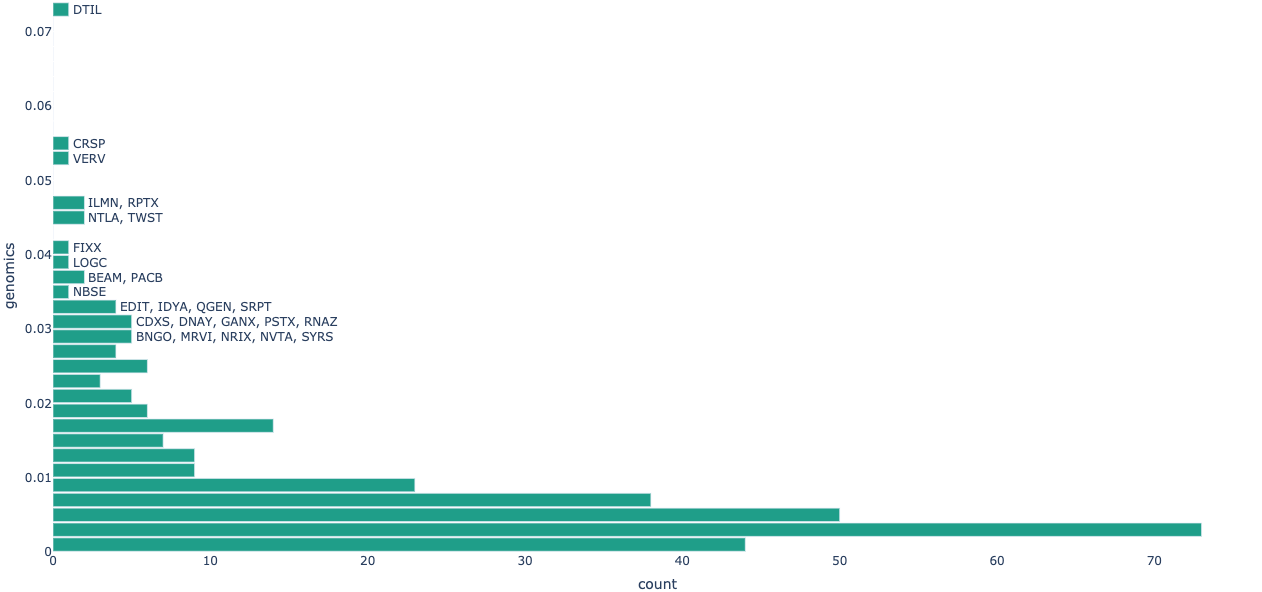

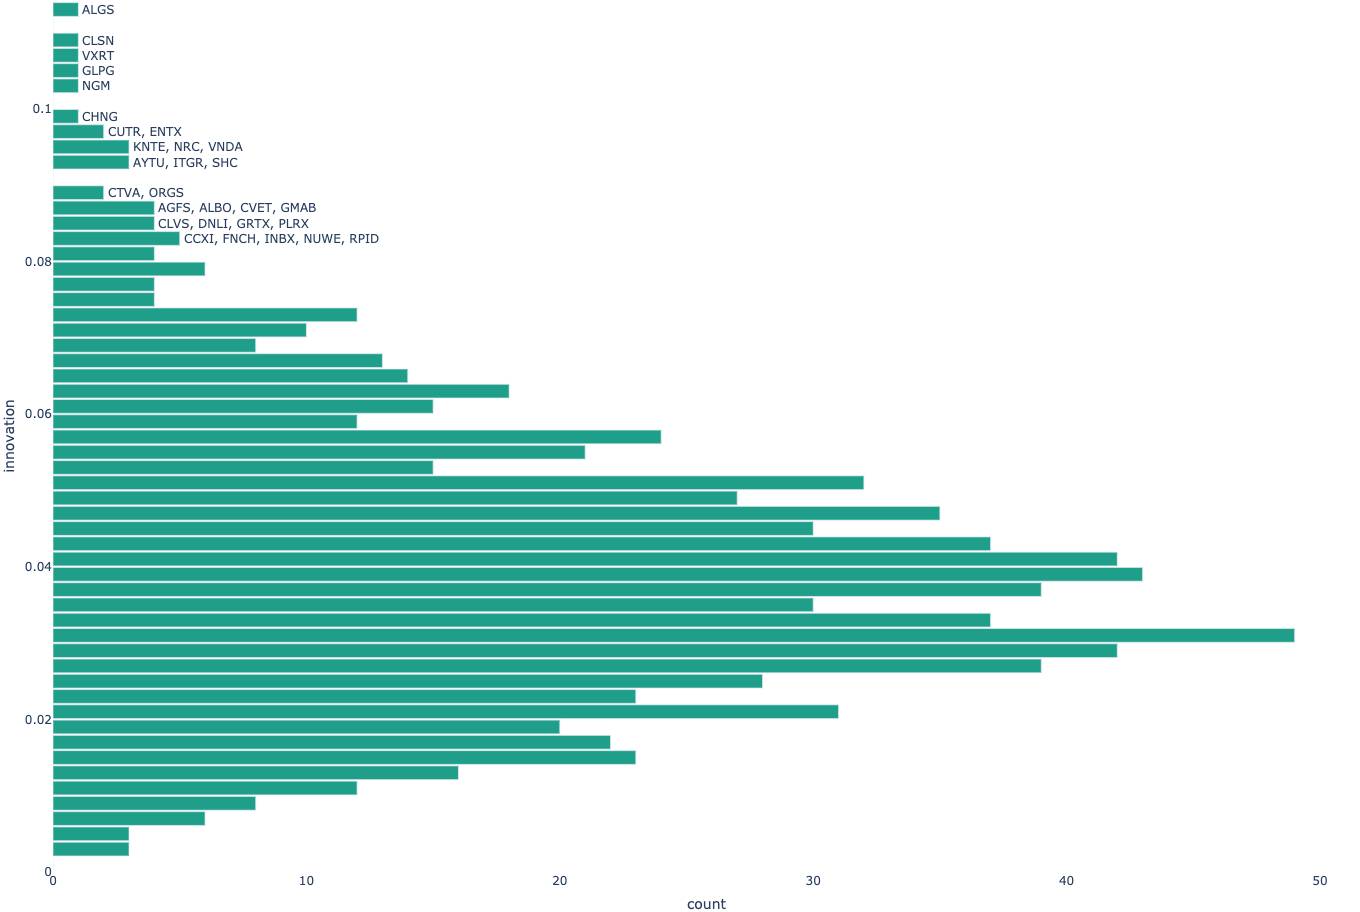

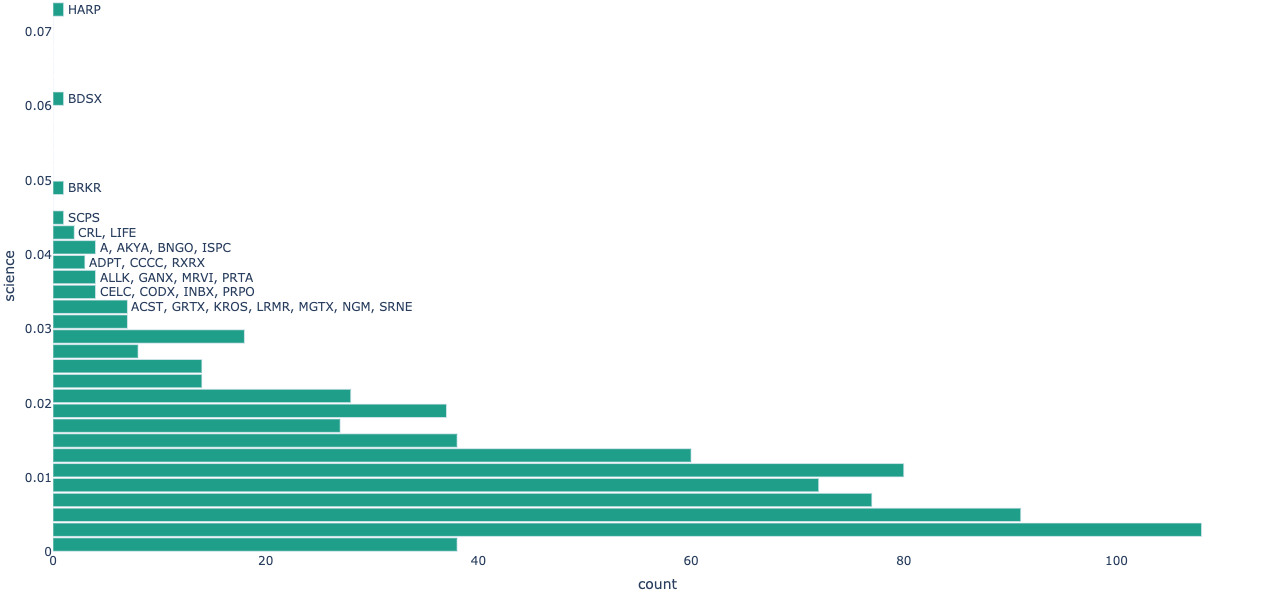

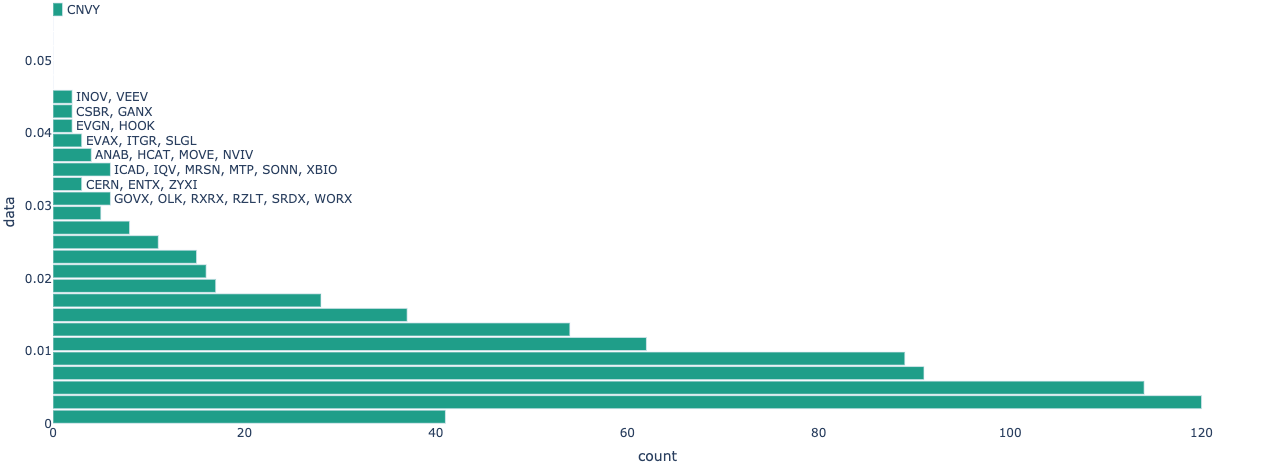

In [7]:
def histplot(category):
    data = genomics_companies[(genomics_companies['count_words']>100)&(genomics_companies[f'ratio_{category}']>0)].sort_values(f'ratio_{category}', ascending=False).reset_index(drop=True)
    data['annotation_position_x'] = data[f'ratio_{category}'].apply(lambda x: (np.floor(x/0.002)*0.002)+0.001)
    data = pd.merge(
        data,
        data.groupby('annotation_position_x')['ticker'].count().to_frame('annotation_position_y').reset_index(),
        on='annotation_position_x',
        how='left'
    )
    
    counts, bins = np.histogram(data[f'ratio_{category}'], bins=[x/1000 for x in range(0, 2*int(np.ceil(500*data[f'ratio_{category}'].max())+1), 2)])
    bin_end = bins[-1]
    bins = 0.5 * (bins[:-1] + bins[1:])

    fig = px.bar(
        y=bins,
        x=counts,
        labels={'y': category, 'x': 'count'},
        color_discrete_sequence=[plotly.colors.get_colorscale('viridis')[5][1]],
        orientation='h'
    )

    fig.update_layout(
        bargap=0.1,
        width=10*max(counts),
        height=8000*bin_end,
        plot_bgcolor='rgba(0, 0, 0, 0)',
        showlegend=False,
        margin=dict(b=0,l=0,r=0,t=0,pad=0),
        xaxis=dict(rangemode='nonnegative')
    )

    sum_annotated = 0
    for x in data['annotation_position_x'].unique():
        tickers = sorted(data[data['annotation_position_x']==x]['ticker'].tolist())
        fig.add_annotation(
            y=x,
            x=data[data['annotation_position_x']==x]['annotation_position_y'].unique()[0],
            text=', '.join(tickers),
            showarrow=False,
            textangle=0,
            ay=0,
            xanchor='left',
            xshift=2
        )
        sum_annotated += len(tickers)
        if sum_annotated > 25:
            break
    
    os.makedirs('fig', exist_ok=True)
    fig.write_image(f'fig/histplot_{category}.png', scale=10)
    fig.show()

histplot('genomics')
histplot('innovation')
histplot('science')
histplot('data')

### Visualize the words that contributed to each category
For both all words and for each of our categories, we'll use a wordcloud to show the words that contributed to that group and proportionally which words were found most often.

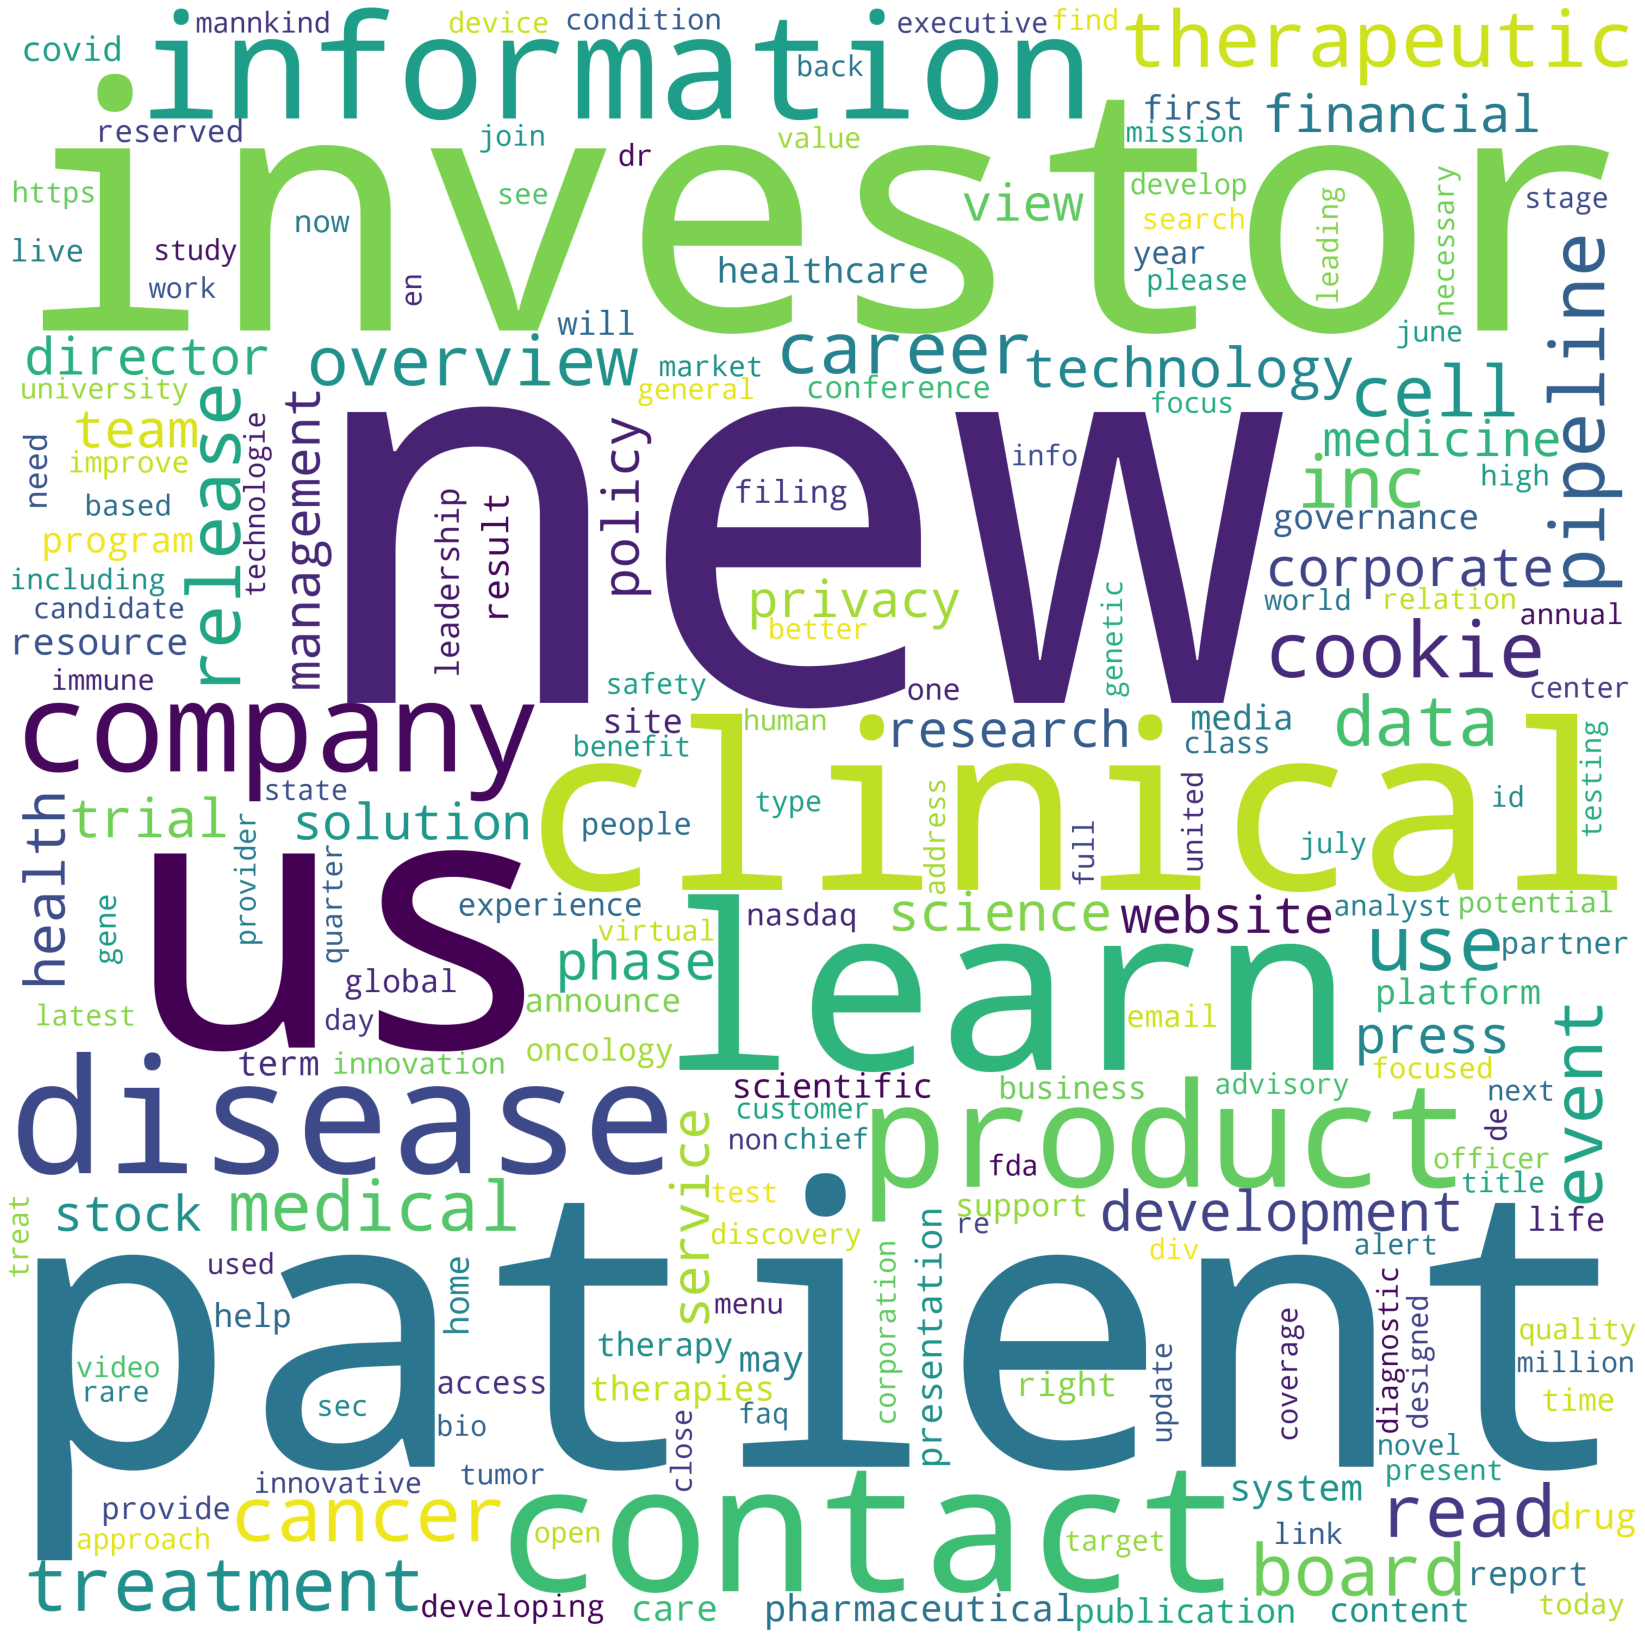

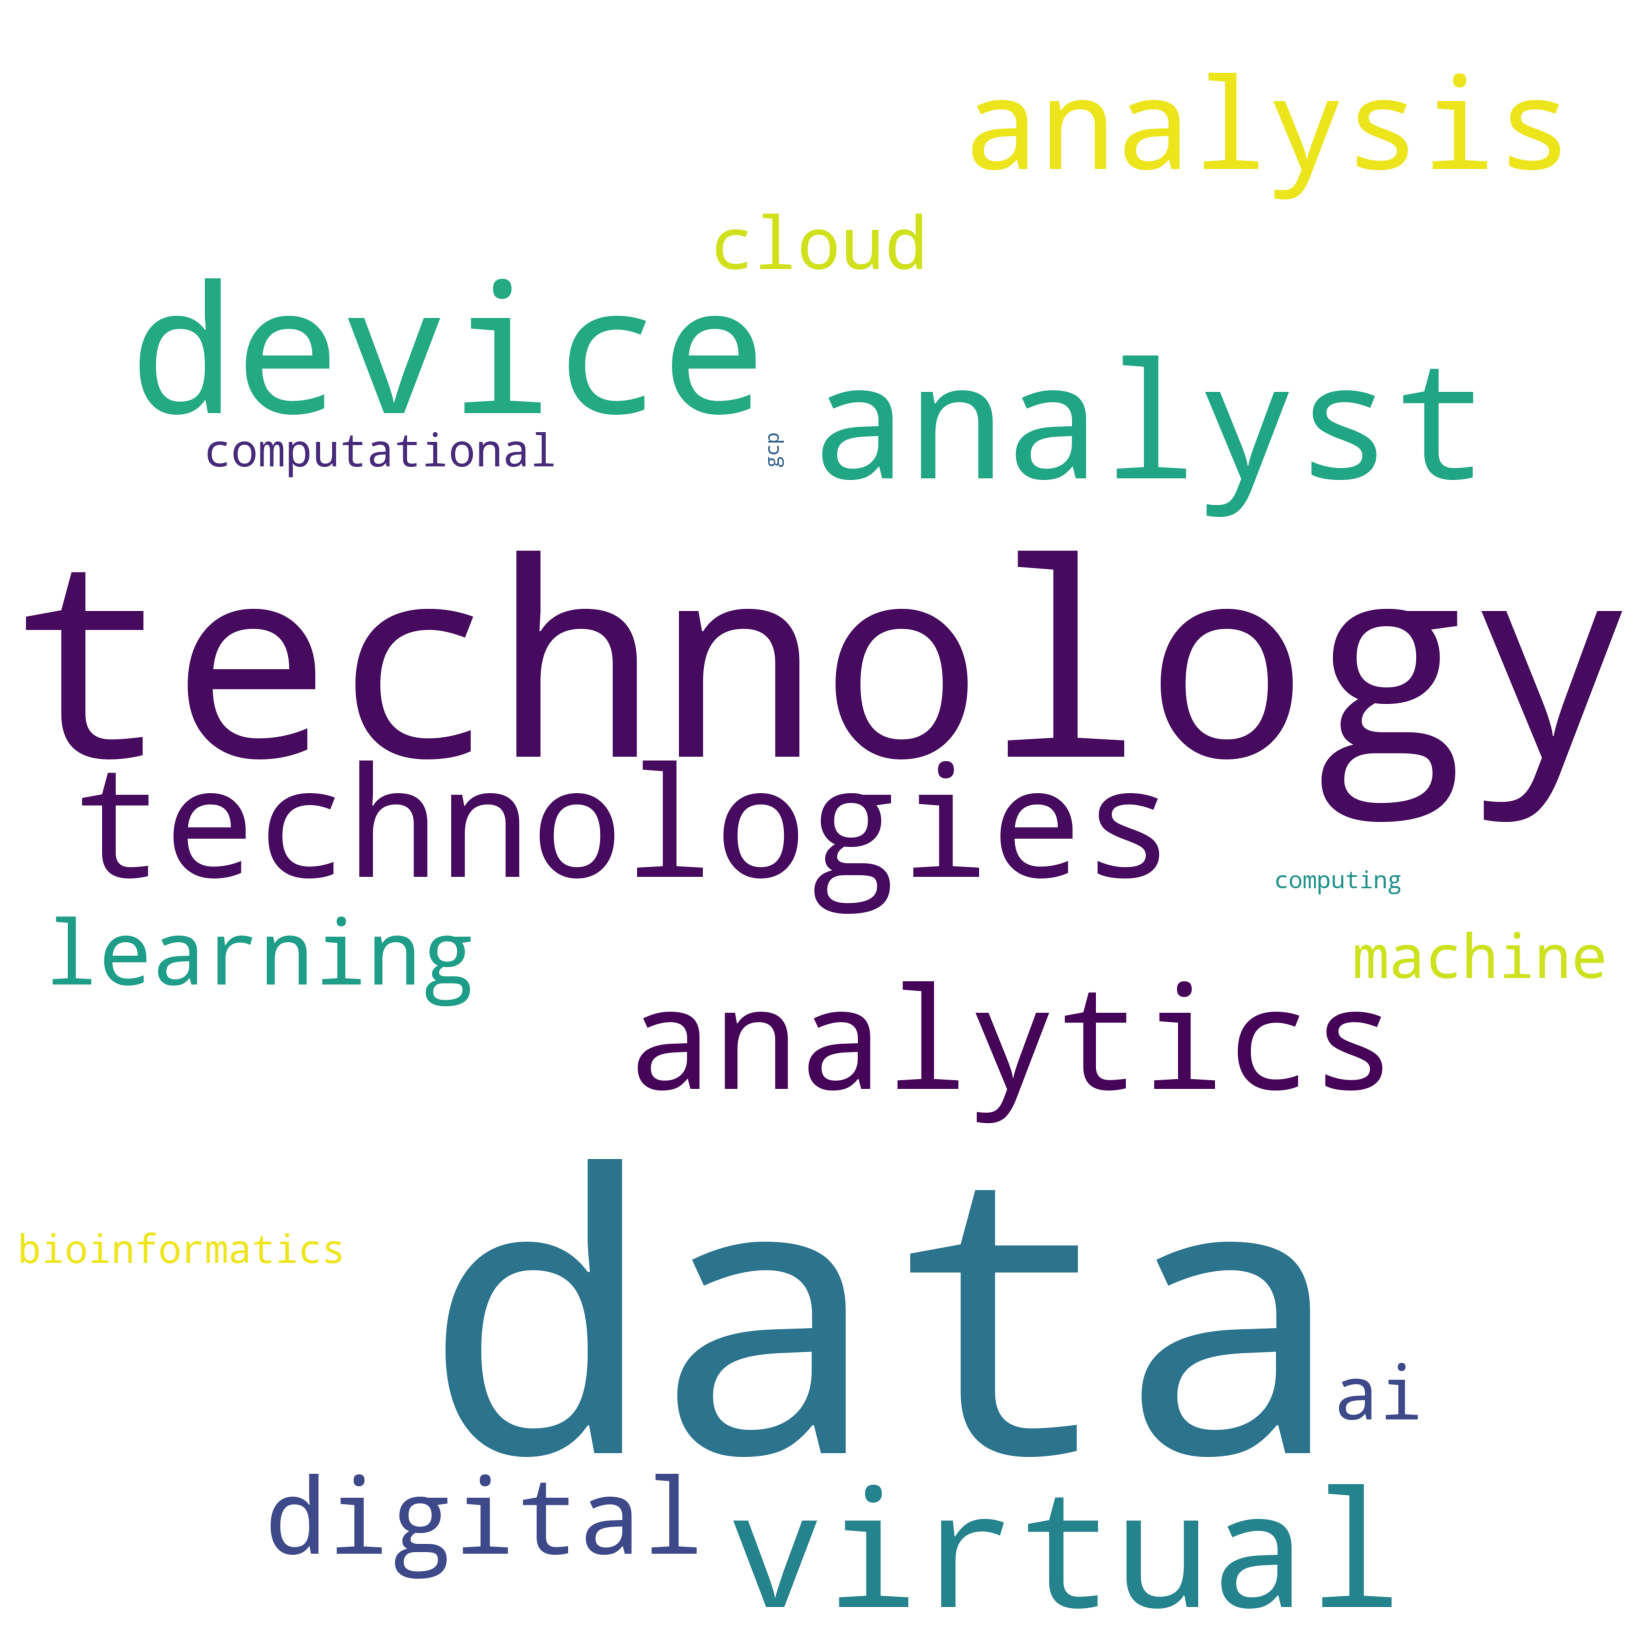

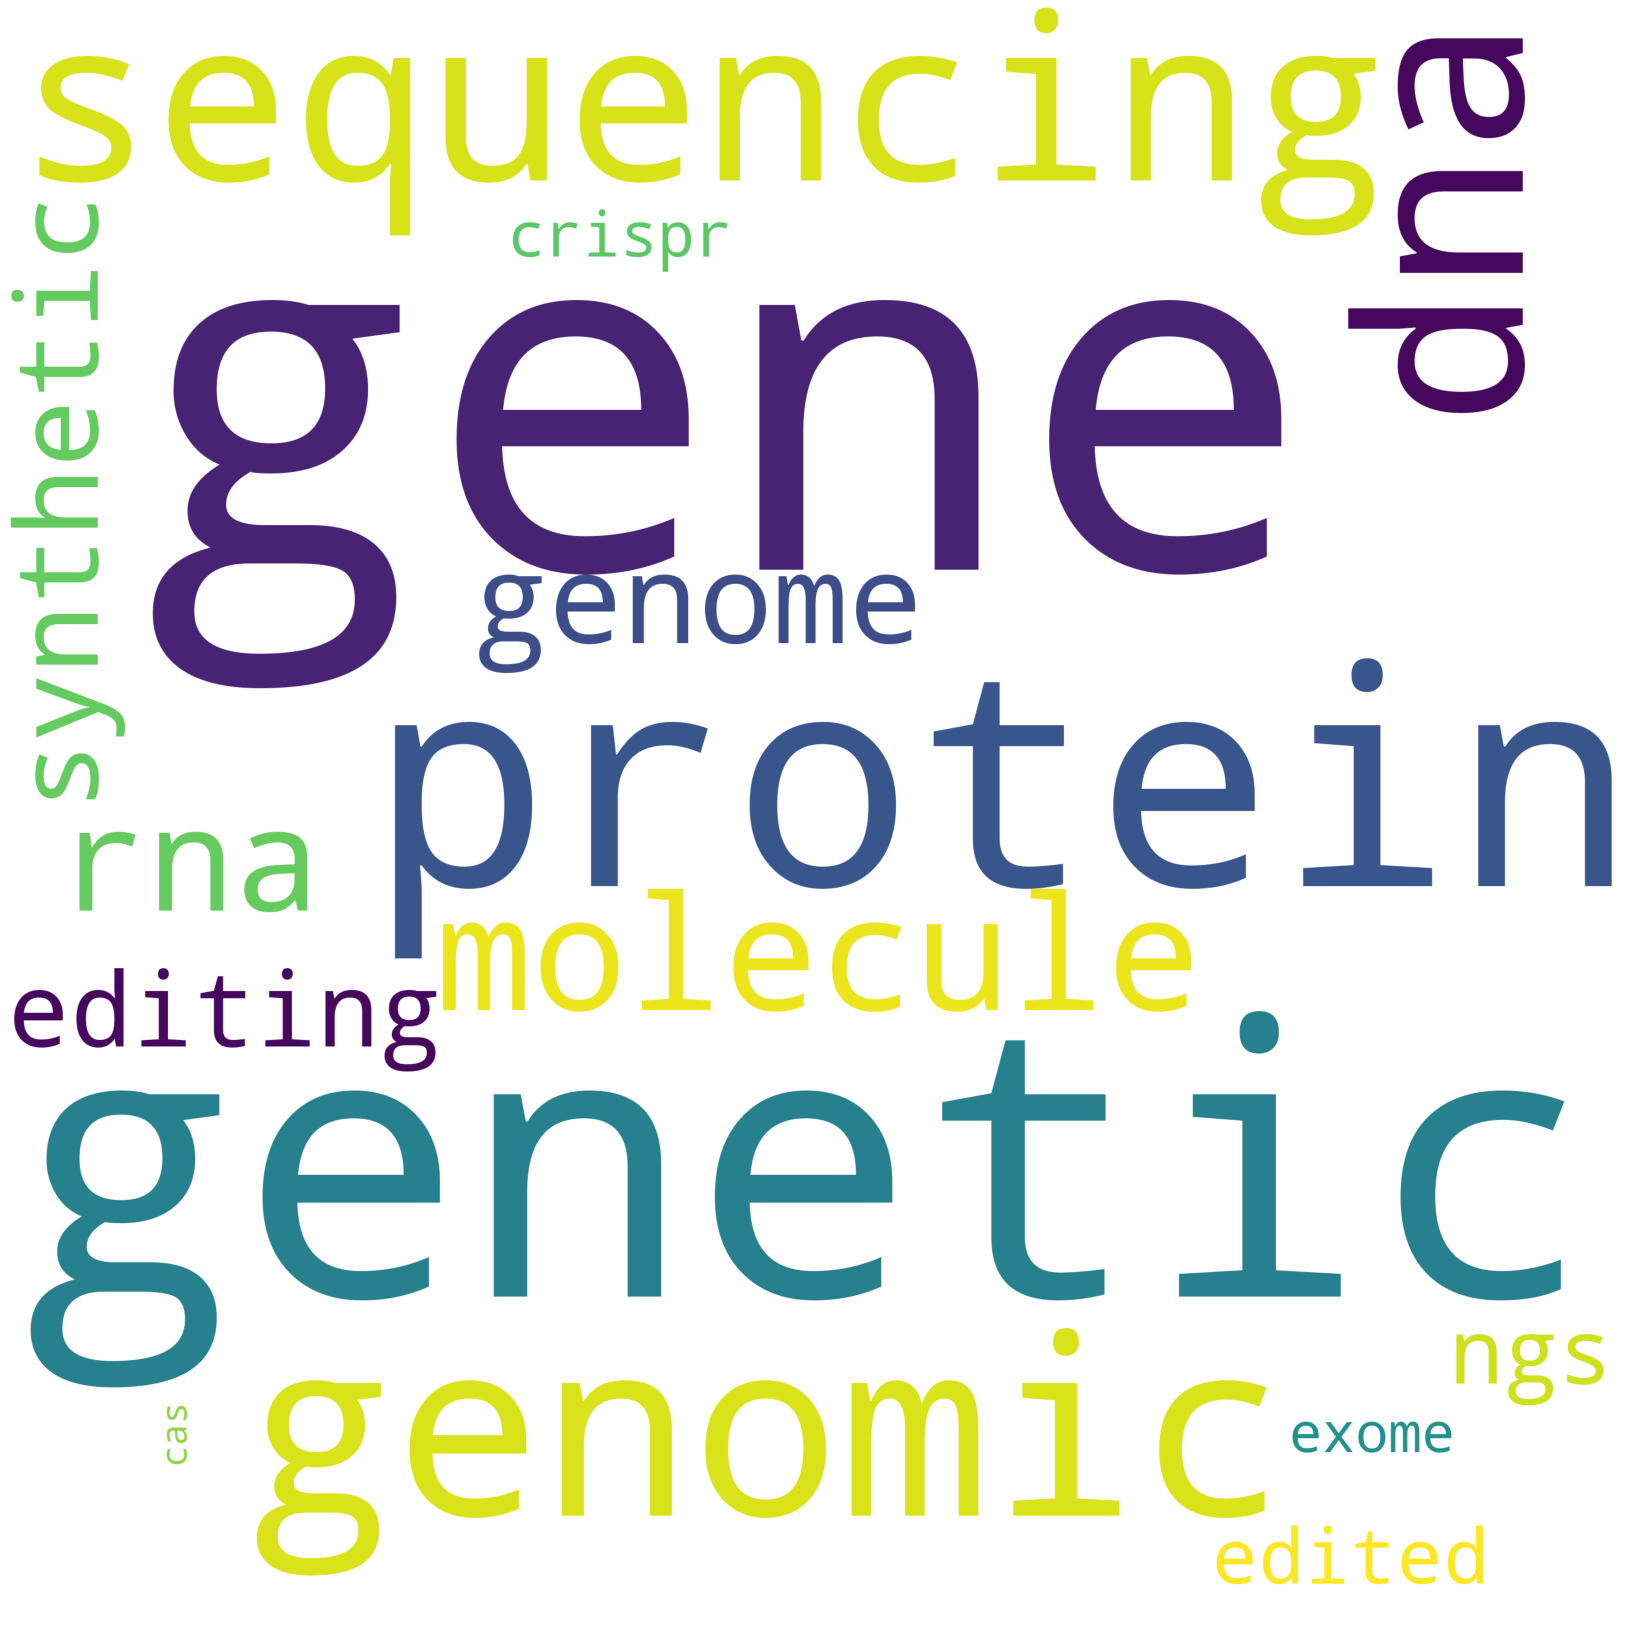

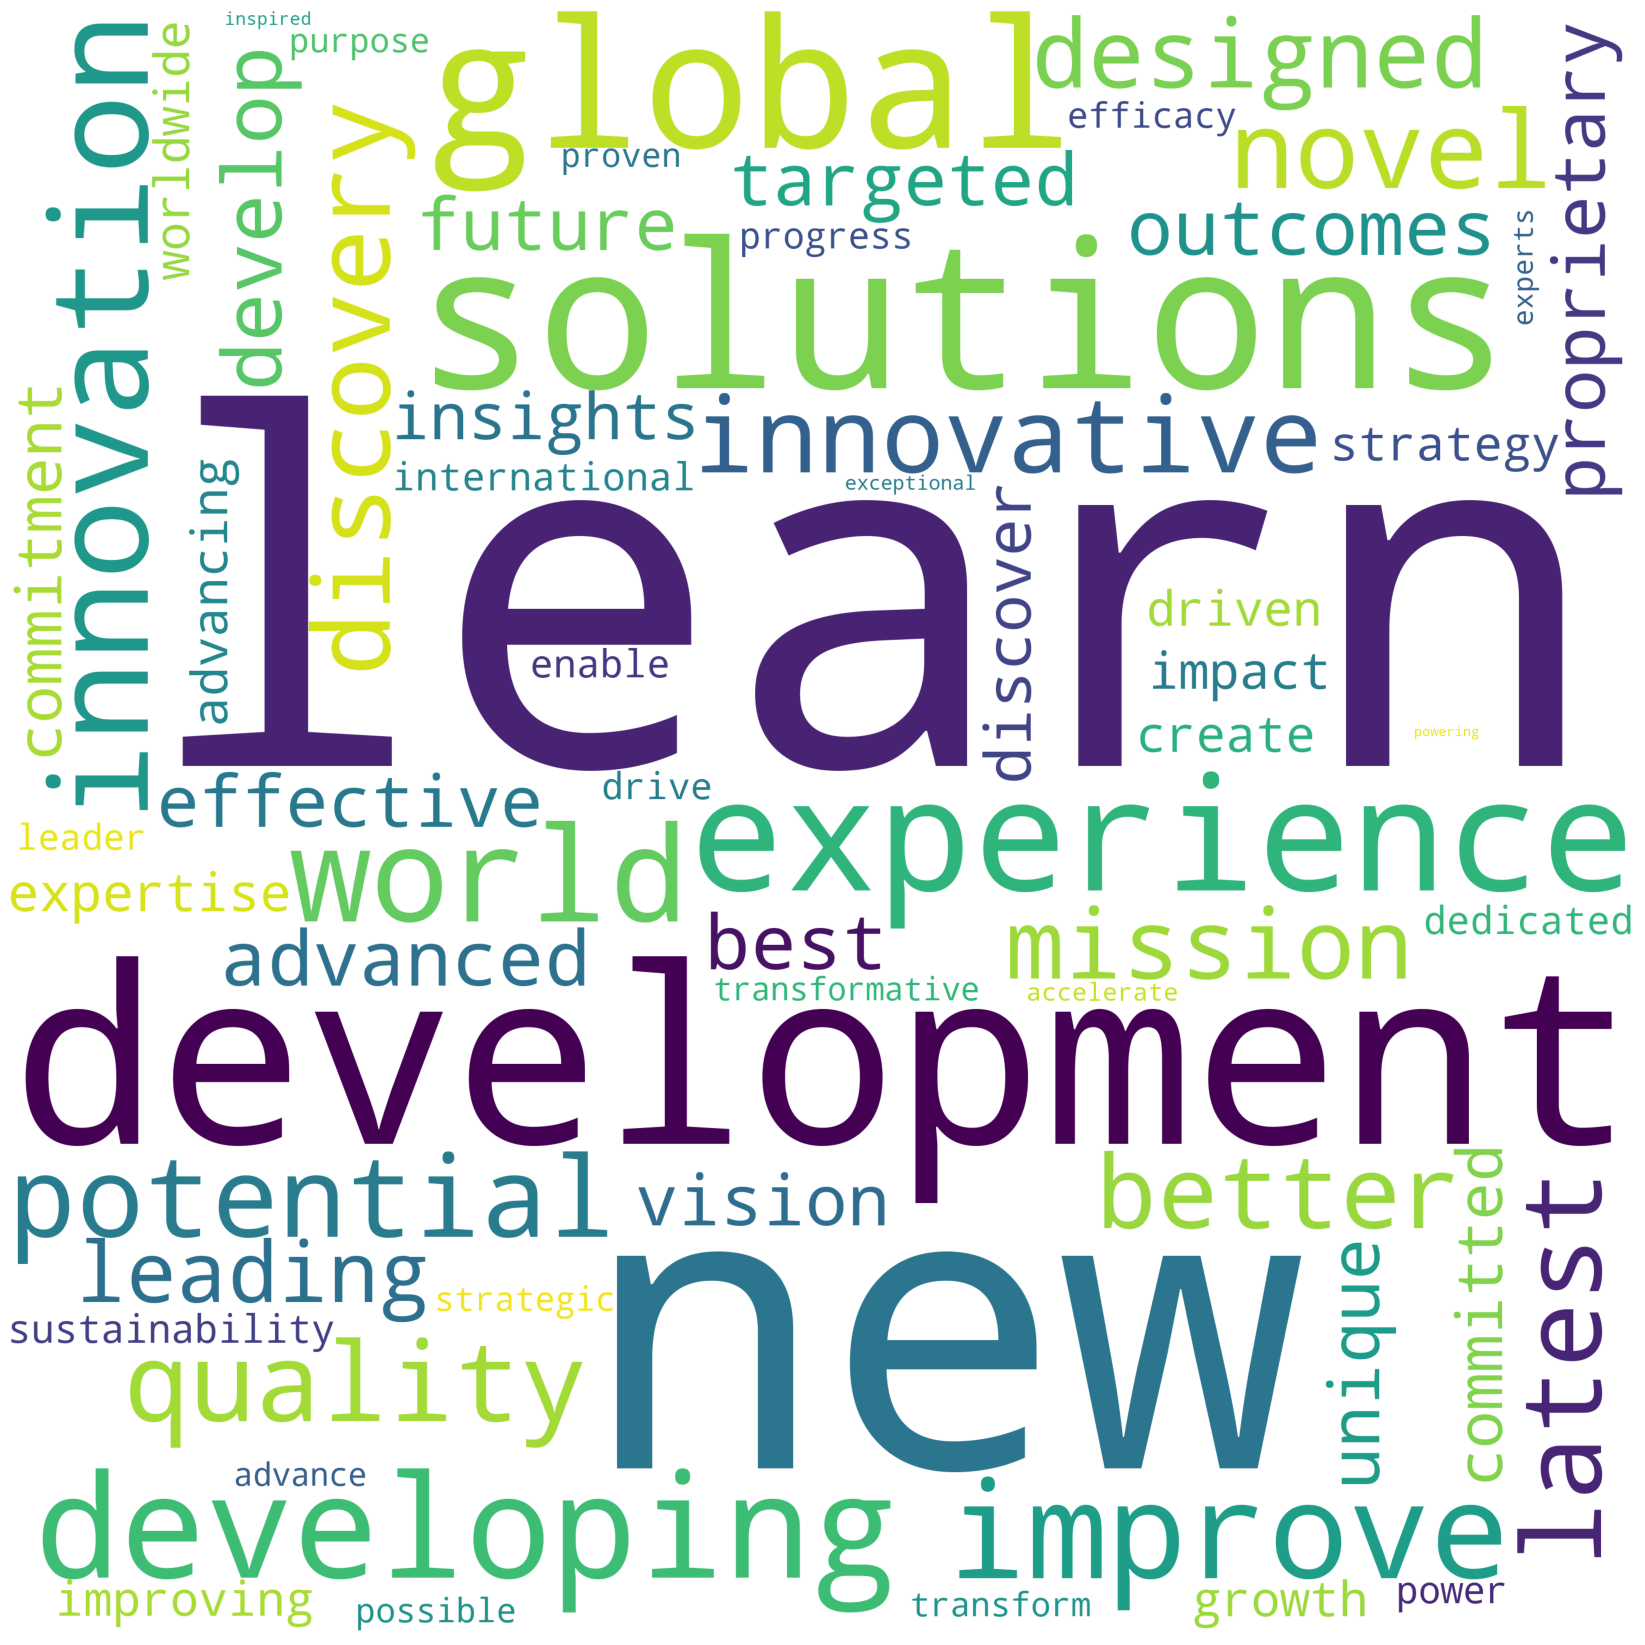

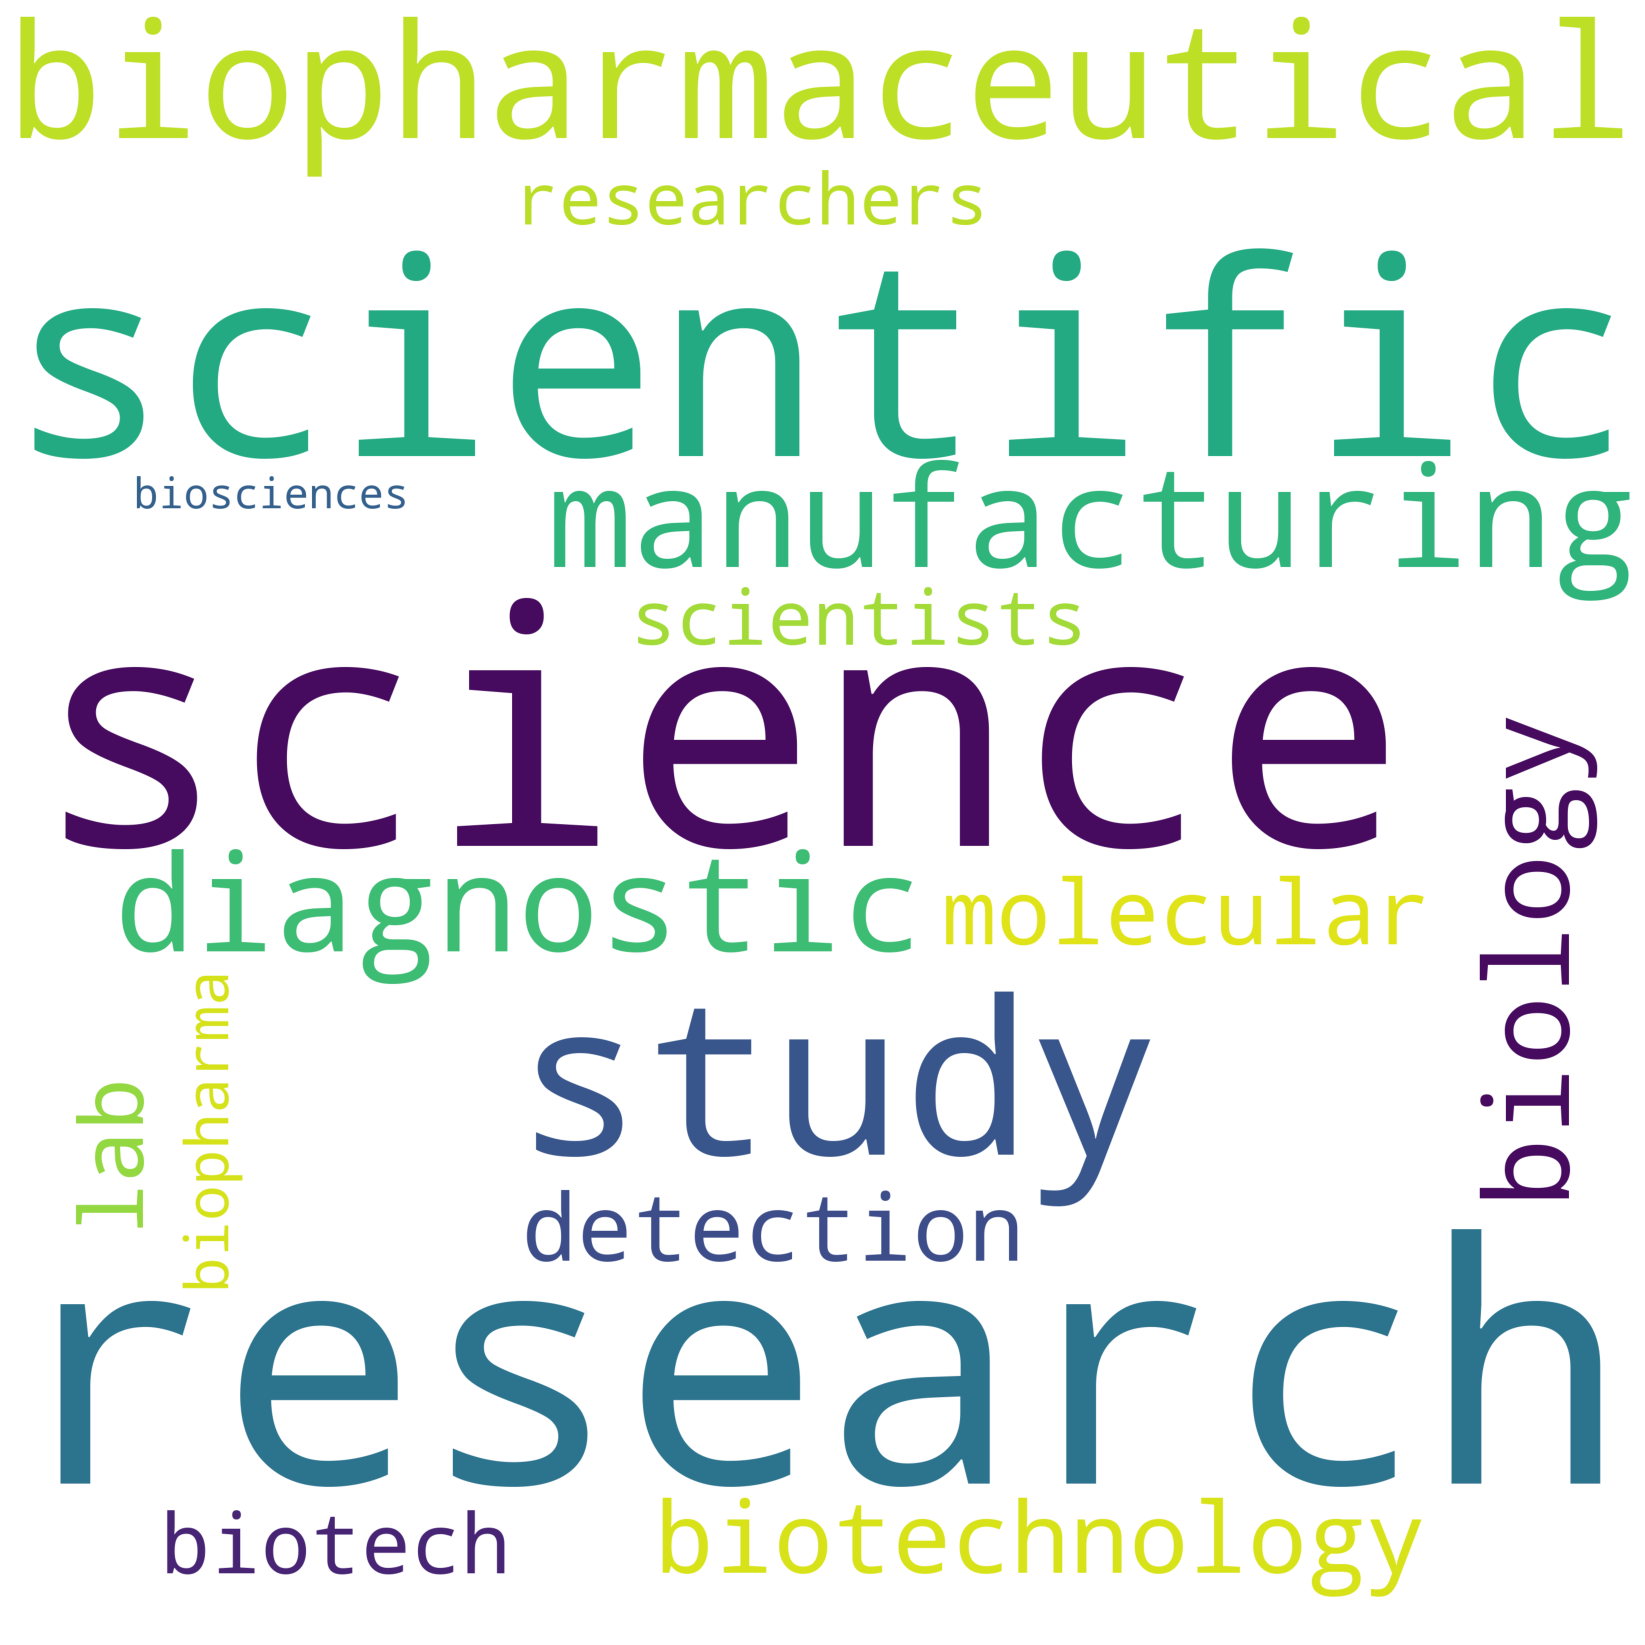

In [8]:
def all_text():
    text = ' '.join([y for x in genomics_companies['companysite_words'].tolist() for y in x])
    return text


def category_text(category):
    text = ' '.join([k for k,v in pd.DataFrame.from_dict(genomics_companies[f'count_{category}'].tolist()).sum().to_dict().items() for i in range(v)])
    return text


def wordcloud(text, fn):
    wordcloud = WordCloud(
        width = 3000,
        height = 3000,
        random_state=1,
        background_color='white',
        colormap='viridis',
        collocations=False,
        stopwords=STOPWORDS
    ).generate(text)
    plt.figure(figsize=(30, 30))
    plt.imshow(wordcloud)
    plt.axis("off");
    plt.savefig(f'fig/wordcloud_{fn}.png', bbox_inches='tight', pad_inches=0, dpi=600)

wordcloud(all_text(), 'all')
wordcloud(category_text('data'), 'data')
wordcloud(category_text('genomics'), 'genomics')
wordcloud(category_text('innovation'), 'innovation')
wordcloud(category_text('science'), 'science')

### Fundamentals
We'll finally assess some basic fundamental financial metrics for our list of genomics companies. We'll focus on three metrics: (1) Revenue, (2) Research and Development Expense, and (3) Equity. For each metric, we'll calculate growth in that metric for the most recently reported trailing 12-month value as compared to that value one year prior. These three metrics were chosen to capture a view of growth in the revenue the company is bringing in, and how they are deploying their cash to both new research to support future innovation from the company and to support the overall growth of the value of the company for shareholders.

In [9]:
fund_data = genomics_companies.copy()
# select fundamentals data for genomics companies only
sf1data_mrt = sf1data_mrt[sf1data_mrt['ticker'].isin(genomics_companies['ticker'].tolist())].reset_index(drop=True)

Calculate the change in the metric value for revenue, rnd, and equity.

In [10]:
end_date = datetime.date.today().isoformat()

def metric_change(ticker, metric, data):
    """calculate the difference in the metric for the past period compared to the previous period"""
    if ticker in data.index.unique():
        subdf = data.loc[[ticker]]
        subdf = (
            subdf[subdf['reportperiod']<=end_date]
            .sort_values('reportperiod')
            .reset_index(drop=True)
        )
        current_date = subdf['reportperiod'].iloc[-1]
        current = subdf[metric].iloc[-1]
        previous_date = f'{int(current_date[:4])-1}{current_date[4:]}'
        if previous_date in subdf['reportperiod'].tolist():
            previous = subdf[subdf['reportperiod']==previous_date][metric].iloc[-1]
            return (current / previous) - 1
        else:
            return np.nan
    else:
        return np.nan

fund_data['revenue_change'] = fund_data['ticker'].apply(metric_change, metric='revenue', data=sf1data_mrt.set_index('ticker'))
fund_data['rnd_change'] = fund_data['ticker'].apply(metric_change, metric='rnd', data=sf1data_mrt.set_index('ticker'))
fund_data['equity_change'] = fund_data['ticker'].apply(metric_change, metric='equity', data=sf1data_mrt.set_index('ticker'))

### Visualize the change in value for these metrics
We'll filter the data to a baseline of those companies that have at least 25% growth in revenue and any level of growth in rnd and in equity.  
Then, we'll create a strip plot of the change values for these metrics for the filtered company list.

In [11]:
def stripplot(metric):
    fig = px.strip(
        fund_data[
            (fund_data['revenue_change']>=0.25)&(fund_data['revenue_change']!=np.Inf)&
            (fund_data['rnd_change']>0)&(fund_data['rnd_change']!=np.Inf)&
            (fund_data['equity_change']>0)&(fund_data['equity_change']!=np.Inf)
        ],
        x=f'{metric}_change',
        hover_name='ticker',
        height=400,
        width=1200,
        orientation='h',
        color_discrete_sequence=[plotly.colors.get_colorscale('viridis')[5][1]],
    )
    
    fig.update_layout(
        plot_bgcolor='rgba(0, 0, 0, 0)',
        margin=dict(b=0,l=0,r=0,t=0,pad=0),
        xaxis={'tickformat': ',.0%', 'title_text': f'{metric} growth', 'gridcolor': '#d3d3d3'},
        yaxis={'range': [-0.1,0.1]}
    )
    
    fig.write_image(f'fig/yoy_change_{metric}.png', scale=1)
    fig.show()
    
count_pass = len(
    fund_data[
        (fund_data['revenue_change']>=0.25)&(fund_data['revenue_change']!=np.Inf)&
        (fund_data['rnd_change']>0)&(fund_data['rnd_change']!=np.Inf)&
        (fund_data['equity_change']>0)&(fund_data['equity_change']!=np.Inf)
    ]
)

print(f'There are {count_pass} companies that pass the filter.')

There are 93 companies that pass the filter.


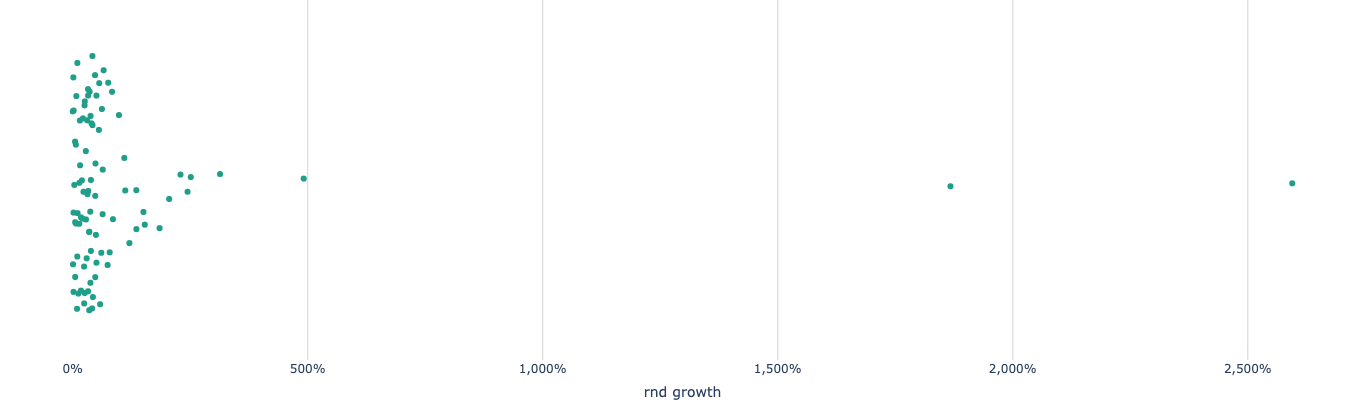

In [12]:
stripplot('rnd')

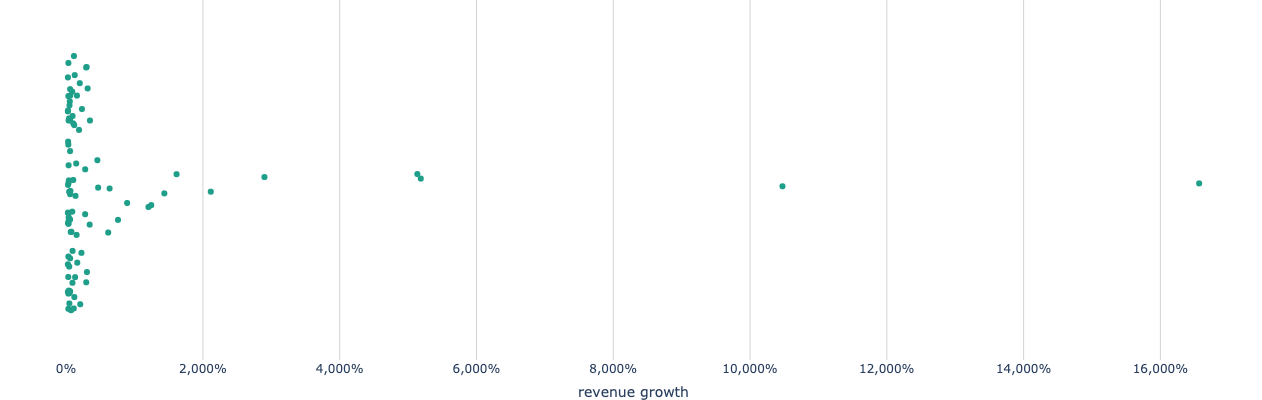

In [13]:
stripplot('revenue')

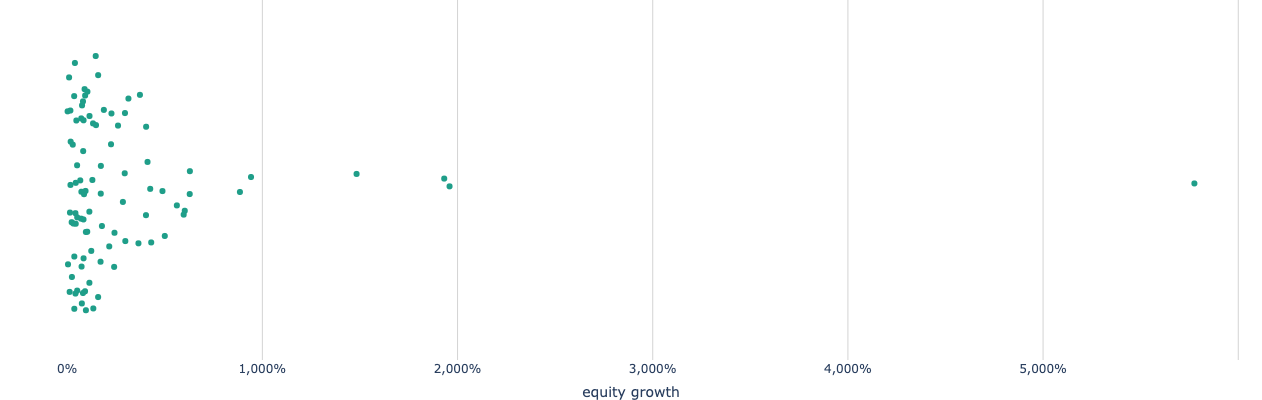

In [14]:
stripplot('equity')

Write the change values for the three metrics to a csv file for those companies that passed the filter.

In [15]:
fund_data[
    (fund_data['revenue_change']>=0.25)&(fund_data['revenue_change']!=np.Inf)&
    (fund_data['rnd_change']>0)&(fund_data['rnd_change']!=np.Inf)&
    (fund_data['equity_change']>0)&(fund_data['equity_change']!=np.Inf)
][['ticker', 'companyname', 'revenue_change', 'rnd_change', 'equity_change']].to_csv('data/fund_results.csv', index=False)

### Companies that rank highly for website content and fundamentals
We'll get a list of the companies that passed our fundamentals filter and that ranked above the median value for ratio of "Genomics" and "Innovation" content on their websites.

In [16]:
for x in fund_data[
    (fund_data['revenue_change']>=0.25)&(fund_data['revenue_change']!=np.Inf)&
    (fund_data['rnd_change']>0)&(fund_data['rnd_change']!=np.Inf)&
    (fund_data['equity_change']>0)&(fund_data['equity_change']!=np.Inf)&
    (fund_data['ratio_genomics']>=fund_data['ratio_genomics'].median())&
    (fund_data['ratio_innovation']>=fund_data['ratio_innovation'].median())
]['ticker'].tolist():
    print(x)

AQB
ATEC
AUTL
AXNX
AYTU
BCYC
BGNE
BNTX
CCXI
CDNA
CODX
CSBR
DNLI
EDIT
EXAS
EYPT
FLGT
GMAB
GRTS
HZNP
IMTX
INO
LGND
LPTX
MGNX
MRNA
MTBC
ONCT
OPGN
PTGX
QTNT
RGNX
SDGR
SELB
SGEN
SYRS
TBIO
TDOC
TELA
TWST
TXG
VEEV
VIR
